# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

## Load raw split frame

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [4]:
import pyarrow.parquet as pq
import pyarrow

## Load data

In [5]:
data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/")

In [6]:
data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/scip/20220713131400/")

In [7]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in data_dir.glob("*.parquet")
], axis=0)

In [8]:
def map_to_name(r):
    return "wbc{group}_{part}{fix}".format(group=int(r.meta_group)+2, part=r.meta_part, fix="" if r.meta_fix is None else "_"+r.meta_fix)
df["meta_sample"] = df.iloc[:, [3,4,5]].apply(map_to_name, axis=1)

In [9]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_dir = data_root / "meta/"
pop_files = list(Path(pop_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}

    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
            with open(pop_file, "r") as fh:
                content = fh.read()
                if len(content) > 0:
                    indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
                    for idx in indices:
                        if ("early" in pop_file.stem) or ("late" in pop_file.stem):
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 3)+1:]
                        else:
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 2)+1:]

In [10]:
def map_to_class(x):
    try:
        s = pops[x.meta_sample]
        return s[x.meta_object_number]
    except:
        return "unknown"

df["meta_label"] = df[["meta_sample", "meta_object_number"]].apply(map_to_class, axis=1)

In [11]:
df.shape

(548100, 4342)

In [12]:
df[df["meta_group"].isin(['1', '2']) & (df["meta_fix"] == "early")].shape

(209194, 4342)

<AxesSubplot:xlabel='count', ylabel='meta_group'>

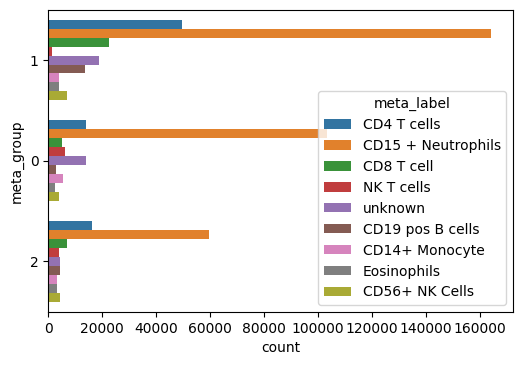

In [13]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=df, y="meta_group", hue="meta_label")

In [14]:
df["meta_label"].value_counts()

CD15 + Neutrophils    326842
CD4 T cells            79680
unknown                37120
CD8 T cell             34564
CD19 pos B cells       20876
CD56+ NK Cells         15488
CD14+ Monocyte         12414
NK T cells             11550
Eosinophils             9566
Name: meta_label, dtype: int64

In [15]:
df = df.reset_index(drop=True)

In [16]:
df.columns = ["meta"+c[len("meta_threshold"):] if any(m in c for m in ["bbox", "regions"]) else c for c in df.columns]

In [17]:
pq.write_table(
    pyarrow.Table.from_pandas(df), data_dir / "features.parquet")